In [17]:
## Add path to sys
import sys
sys.path.append('../')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from preprocessing import data_processing
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
train_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/train/'
test_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/test/'
IMG_SIZE = (224,224)

X_train, y_train, labels = data_processing.load_data_tonumpy(train_dataset, IMG_SIZE)
X_test, y_test, _ = data_processing.load_data_tonumpy(test_dataset, IMG_SIZE)


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


202 images loaded from D:/Projects/tumai_braintumor_classification/dataset/train/ directory.


100%|██████████| 2/2 [00:00<00:00, 16.58it/s]

51 images loaded from D:/Projects/tumai_braintumor_classification/dataset/test/ directory.


## Image cropping example
https://www.kaggle.com/code/fadhlalhafizh/brain-tumor-vgg16-resnet50-inceptionv3

In [6]:
import cv2
import imutils

In [7]:
img = X_train[3]
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

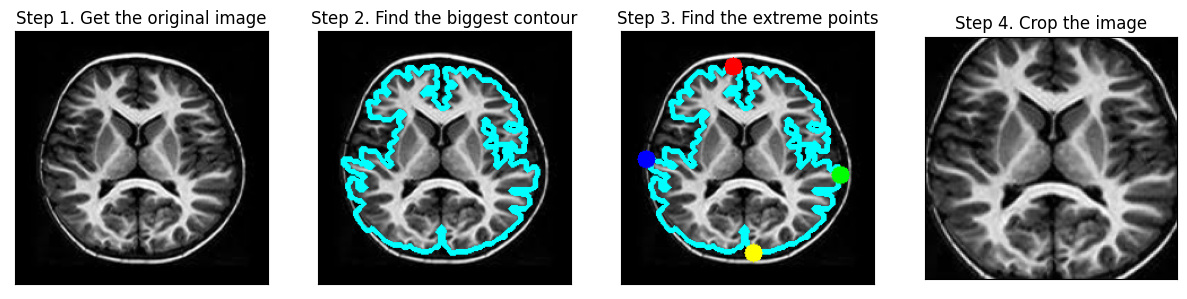

In [8]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()


In [5]:
# apply this for each set
X_train_crop = data_processing.crop_imgs(set_name=X_train)
X_test_crop = data_processing.crop_imgs(set_name=X_test)

### Trying TL Models

In [36]:
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from matplotlib import pyplot 
from numpy import expand_dims

In [37]:
def preprocess_for_vgg(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [38]:
X_train_prep = preprocess_for_vgg(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_for_vgg(set_name=X_test_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


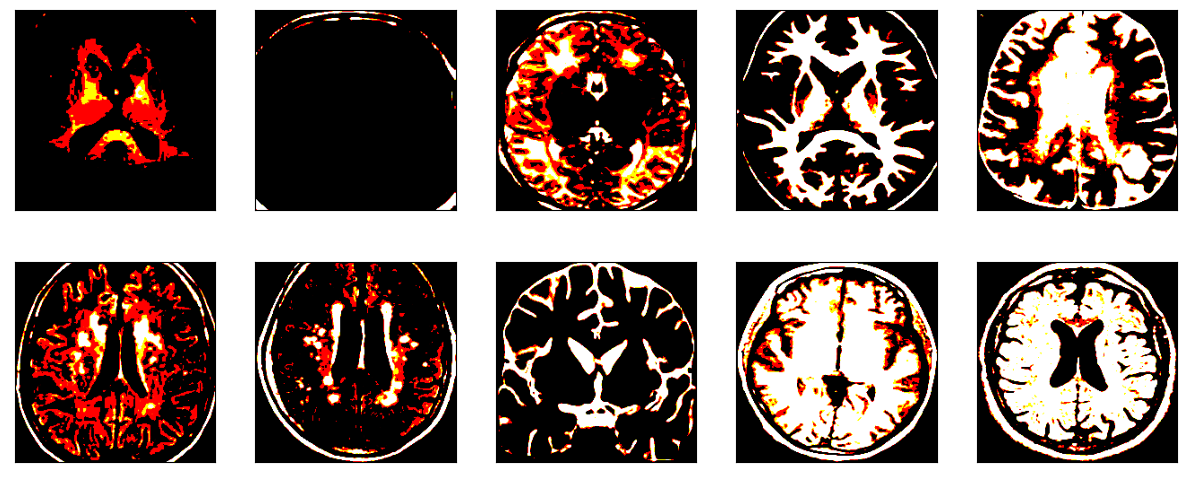

In [39]:
## Plot 10 images from X_train_crop
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train_prep[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [49]:
## Make a VGG16 model and freeze the layers and add a head 
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = False
model = Sequential()
model.add(vgg16)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


## Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               12845568  
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                                 
Total params: 27,560,769
Trainable params: 12,846,081
Non-trainable params: 14,714,688
_________________________________________________________________


In [50]:
model.fit(
    X_train_prep,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_prep, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10


7/7 [==============================] - 29s 4s/step - loss: 47.0330 - accuracy: 0.5396 - val_loss: 15.2622 - val_accuracy: 0.7451
Epoch 2/10
7/7 [==============================] - 28s 4s/step - loss: 11.4129 - accuracy: 0.7277 - val_loss: 2.4113 - val_accuracy: 0.8627
Epoch 3/10
7/7 [==============================] - 29s 4s/step - loss: 2.2041 - accuracy: 0.8762 - val_loss: 4.6846 - val_accuracy: 0.6667
Epoch 4/10
7/7 [==============================] - 29s 4s/step - loss: 0.5376 - accuracy: 0.9307 - val_loss: 0.8036 - val_accuracy: 0.9216
Epoch 5/10
7/7 [==============================] - 29s 4s/step - loss: 0.2456 - accuracy: 0.9604 - val_loss: 0.9092 - val_accuracy: 0.9020
Epoch 6/10
7/7 [==============================] - 28s 4s/step - loss: 0.1205 - accuracy: 0.9802 - val_loss: 0.7619 - val_accuracy: 0.9216
Epoch 7/10
7/7 [==============================] - 28s 4s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.9404 - val_accuracy: 0.8824
Epoch 8/10
7/7 [==========================

In [52]:
model.evaluate(X_test_prep, y_test)

2/2 [==============================] - 6s 2s/step - loss: 0.7619 - accuracy: 0.9216


[0.7619243860244751, 0.9215686321258545]

## Checking the model

In [54]:
from sklearn.metrics import f1_score, confusion_matrix

y_pred = model.predict(X_test_prep)
y_pred = np.where(y_pred > 0.5, 1, 0)

f1_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

2/2 [==============================] - 6s 2s/step


array([[18,  2],
       [ 2, 29]], dtype=int64)

In [72]:
## Get all X_test and y_test with wrong prediction

X_test_wrong = X_test_prep[y_test != y_pred.reshape(-1)]
y_test_wrong = y_test[y_test != y_pred.reshape(-1)]

X_test_right = X_test_prep[y_test == y_pred.reshape(-1)]
y_test_right = y_test[y_test == y_pred.reshape(-1)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


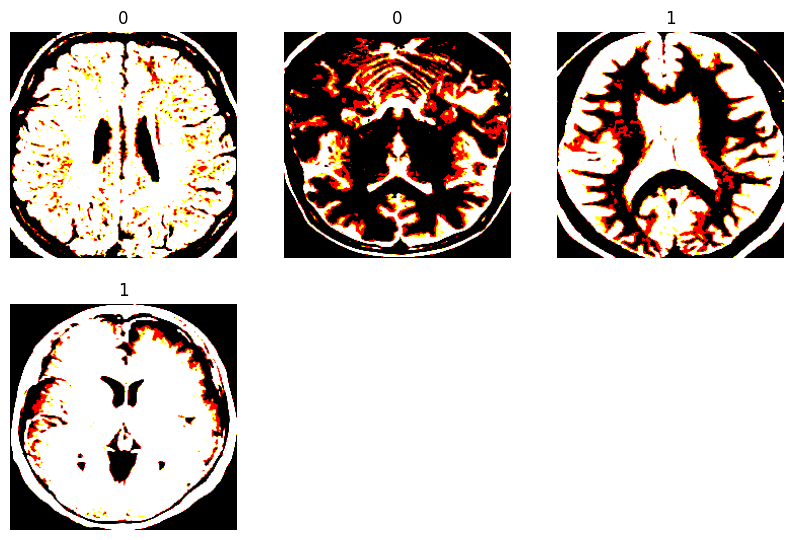

In [74]:
## Plot all wrong prediction

plt.figure(figsize=(10, 10))
for i in range(len(X_test_wrong)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_wrong[i], cmap='gray')
    plt.title(str(y_test_wrong[i]))
    plt.axis("off")

plt.show()

In [76]:
explainer = shap.DeepExplainer(model, data=X_test_prep)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


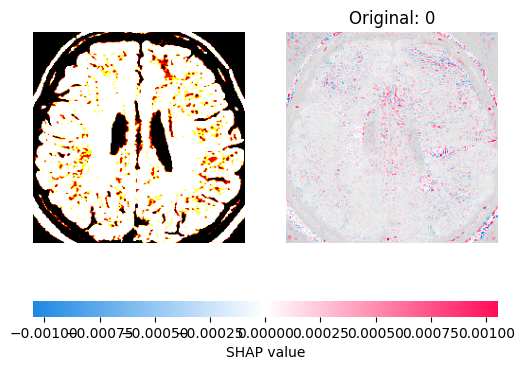

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


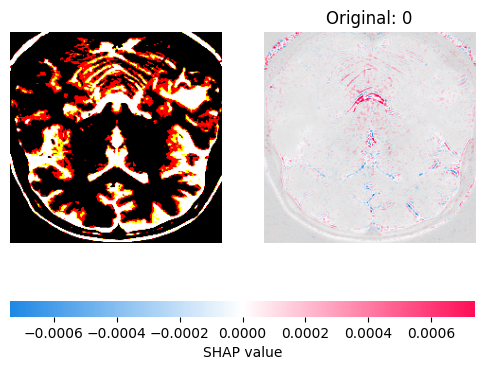

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


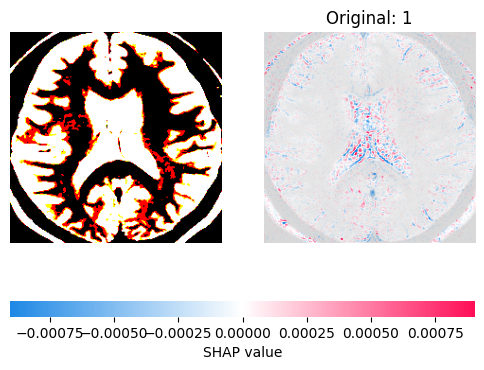

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


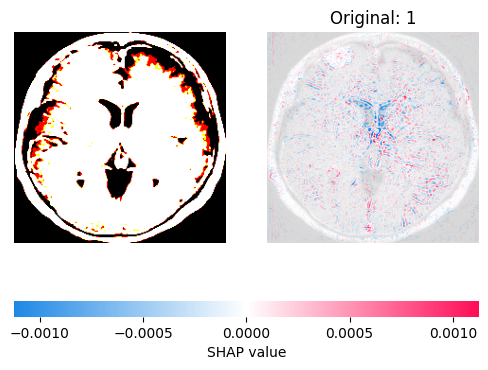

In [77]:
## Using SHAP to explain the model
import shap
# Create an explainer object
for i in range(len(X_test_wrong)):
    # Get a sample the wrong prediction
    sample = X_test_wrong[i].reshape(1, 224, 224, 3)
    # Get the shap values
    shap_values = explainer.shap_values(sample)
    # Plot the shap values
    ## Add the original and probability of the wrong prediction
    shap.image_plot(shap_values, sample, show=False)
    plt.title('Original: ' + str(y_test_wrong[i]))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


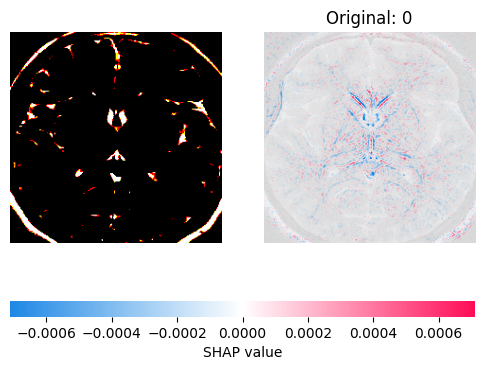

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


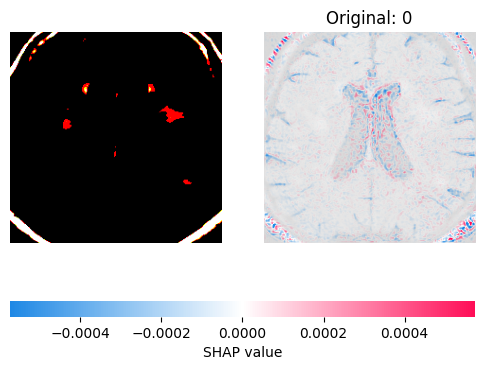

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


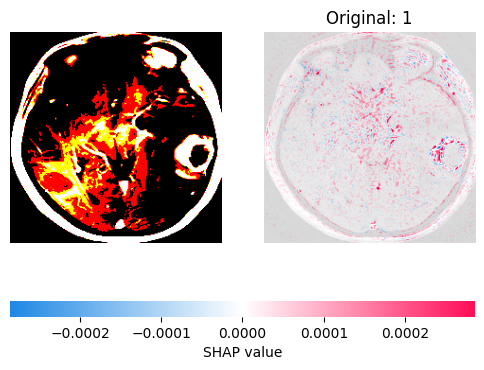

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


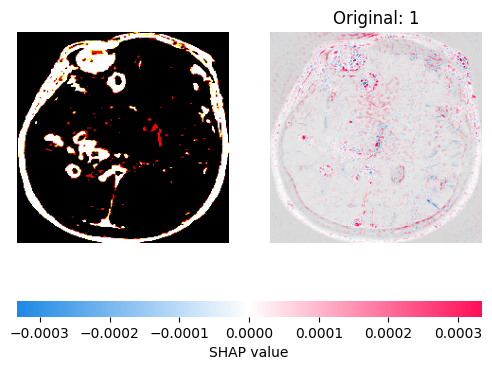

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


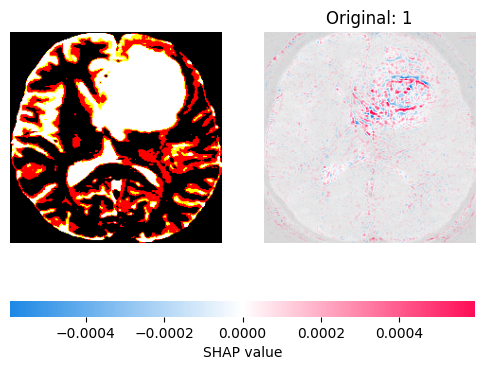

In [85]:
import shap
# Create an explainer object
for i in [0,5,-4,-5,-7]:
    # Get a sample the wrong prediction
    sample = X_test_right[i].reshape(1, 224, 224, 3)
    # Get the shap values
    shap_values = explainer.shap_values(sample)
    # Plot the shap values
    ## Add the original and probability of the wrong prediction
    shap.image_plot(shap_values, sample, show=False)
    plt.title('Original: ' + str(y_test_right[i]))
    plt.show()
